<h1 align="center">All relevant feature selection</h1>
<h2 align="center"> Regression - Boruta and beyond </h2>
<p style="text-align:center">
   Human Bender<br>
</p>


In the original Boruta paper NIPS2003 and cited in the [Boruta paper](https://www.jstatsoft.org/article/view/v036i11/v36i11.pdf) the gini feature importance is used. The gini importance is known to be biased. See [this blog post](https://explained.ai/rf-importance/#5) for a nice illustration and [this one](https://blog.methodsconsultants.com/posts/be-aware-of-bias-in-rf-variable-importance-metrics/) for an explanation why is impurity importance biased. 

#### What's new:

   - The categorical features (they are detected, encoded. The tree-based models are working better with integer encoding rather than with OHE, which leads to deep and unstable trees). If Catboost is used, then the cat.pred (if any) are set up
   - You can use lightGBM, XGBoost and CatBosst (sklearn API only)
   - Allow using sample_weight
   - Supports permutation importance
   - Support SHAP feature importance for lightGBM, XGBoost and CatBosst and does not introduce a direct dependency to the SHAP package nor to the boosting packages (for XGBoost and CatBoost you need to pass the data structure function though)
   - The dependencies which are not part of the [list of scikit-learnn dependencies](https://scikit-learn.org/stable/install.html) are optional. Not part of the distribution but import checks are performed. Those dependencies are `tqdm` (for a nice user notification) and `SHAP` for the Shapley values.
   - Visualization, as in the original R package, based on matplotlib (which is a scikit-learn dependency, see above, but installation is not forced in the setup.py) 
  
Note that for lightGBM with SHAP, the run time for this example is almost the same as for Boruta with gini/impurity feature importance. The IQR (inter-quartile) is much smaller with permutation and SHAP importance.

In [1]:
# from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:95% !important; }</style>"))

import gc
from sklearn.datasets import fetch_openml
from sklearn.utils import Bunch
from sklearn.datasets import load_boston
import pandas as pd
import numpy as np

from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

from boruta import BorutaPy
# plt.style.use('fivethirtyeight')
rng = np.random.RandomState(seed=42)

import warnings
warnings.filterwarnings('ignore')
gc.enable()
gc.collect()

0

In [2]:
%matplotlib inline

# Testing by adding random and genuine predictors to real data

I'll use a classical data set to which I added random predictors (numerical and categorical). An All Relveant FS methods should discard them.
In the unit tests, you'll find examples using artifical data with genuine (correlated and non-linear) predictors and with some random/noise columns.

## Fetch the data

In [3]:
def get_boston_data():
    boston = load_boston()
    rng = np.random.RandomState(seed=42)
    X = pd.DataFrame(boston.data)
    X.columns = boston.feature_names
    X['random_num1'] = rng.randn(X.shape[0])
    X['random_num2'] = np.random.poisson(1, X.shape[0])
    # high cardinality
    X['random_cat'] = rng.randint(10*X.shape[0], size=X.shape[0])
    X['random_cat'] = 'cat_' + X['random_cat'].astype('str')
    # low cardinality
    nice_guys = ['Rick', 'Bender', 'Cartman', 'Morty', 'Fry', 'Vador', 
                 'Thanos', 'Bejita', 'Cell', 'Tinkywinky', 'Lecter', 
                 'Alien', 'Terminator', 'Drago', 'Dracula', 
                 'Krueger', 'Geoffrey', 'Goldfinder', 'Blackbeard', 
                 'Excel', 'SAS', 'Bias', 'Variance', 'Scrum',
                 'Human', 'Garry', 'Coldplay', 'Imaginedragons',
                 'Platist', 'Creationist', 'Gruber', 'KeyserSoze', 'Luthor',
                 'Klaue', 'Bane', 'MarkZ']
    X['random_cat_2'] = np.random.choice(nice_guys, X.shape[0])
    y = pd.Series(boston.target)
    # non linear noisy but genuine predictor to test the ability to detect even genuine noisy non-linearities
    X['genuine_num'] = np.sqrt(y) + np.random.gamma(2, .5, X.shape[0])
    cat_f = ['CHAS', 'RAD', 'random_cat', 'random_cat_2']
    X[cat_f] = X[cat_f].astype(str).astype('category')
    return Bunch(data=X,
                 target=y,
                 sample_weight=None,
                 categorical=cat_f)

def highlight_tick(str_match, figure, color='red', axis='y'):
    if axis == 'y':
        labels = [item.get_text() for item in figure.gca().get_yticklabels()]
        indices = [i for i, s in enumerate(labels) if str_match in s]
        [figure.gca().get_yticklabels()[idx].set_color(color) for idx in indices]
    elif axis == 'x':
        labels = [item.get_text() for item in figure.gca().get_xticklabels()]
        indices = [i for i, s in enumerate(labels) if str_match in s]
        [figure.gca().get_xticklabels()[idx].set_color(color) for idx in indices]
    else:
        raise ValueError("`axis` should be a string, either 'y' or 'x'")

    return figure

In [4]:
boston = get_boston_data()
X, y = boston.data, boston.target

In [5]:
X.dtypes

CRIM             float64
ZN               float64
INDUS            float64
CHAS            category
NOX              float64
RM               float64
AGE              float64
DIS              float64
RAD             category
TAX              float64
PTRATIO          float64
B                float64
LSTAT            float64
random_num1      float64
random_num2        int32
random_cat      category
random_cat_2    category
genuine_num      float64
dtype: object

In [6]:
X.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,random_num1,random_num2,random_cat,random_cat_2,genuine_num
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,0.496714,2,cat_3517,KeyserSoze,6.588640
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,-0.138264,1,cat_2397,Krueger,5.112846
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,0.647689,1,cat_3735,Bane,6.668522
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,1.523030,3,cat_2870,Lecter,6.298638
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,-0.234153,0,cat_1160,Bejita,6.926993


## Model 

Let's use the same model for all the examples

In [7]:
# Let's use lightgbm as booster, see below for using more models
model = LGBMRegressor(random_state=42, verbose=-1, max_depth=5)

## Boruta (vanilla)

the original form, with gini/impurity feature importance. IQR is large.

Boruta iteration:  95%|████████████████████████████████████████████████████████████▊   | 19/20 [00:05<00:00,  3.22it/s]




Boruta finished running using native var. imp.

Iteration: 	20 / 20
Confirmed: 	2
Tentative: 	0
Rejected: 	16
All relevant predictors selected in 00:00:05.91
['RM', 'genuine_num']
Wall time: 6.1 s


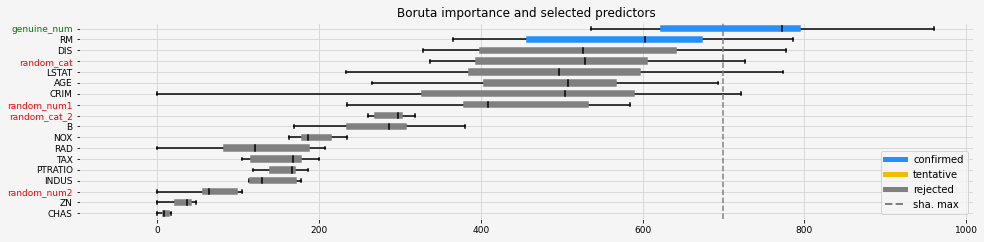

In [8]:
%%time

feat_selector = BorutaPy(model, verbose=1, max_iter=20, random_state=42, importance='native') #, early_stopping=True, n_iter_no_change=20)
feat_selector.fit(X, y, sample_weight=None)
print(feat_selector.support_names_)
fig = feat_selector.plot_importance(n_feat_per_inch=5)

# highlight synthetic random and genuine variables
fig = highlight_tick(figure=fig, str_match='random')
fig = highlight_tick(figure=fig, str_match='genuine', color='green')

In [9]:
feat_selector.tag_df

,predictor,Boruta,Boruta_weak_incl
0,CRIM,0,0
1,ZN,0,0
2,INDUS,0,0
3,CHAS,0,0
4,NOX,0,0
5,RM,1,1
6,AGE,0,0
7,DIS,0,0
8,RAD,0,0
9,TAX,0,0


## Boruta with permutation importance

Not the original form, same process but using permutation importance instead of the gini/impurity one. IQR is small.

Boruta iteration:  95%|████████████████████████████████████████████████████████████▊   | 19/20 [00:29<00:01,  1.54s/it]




Boruta finished running using pimp var. imp.

Iteration: 	20 / 20
Confirmed: 	11
Tentative: 	0
Rejected: 	7
All relevant predictors selected in 00:00:29.20
['CRIM', 'INDUS', 'NOX', 'RM', 'AGE', 'DIS', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'genuine_num']
Wall time: 29.4 s


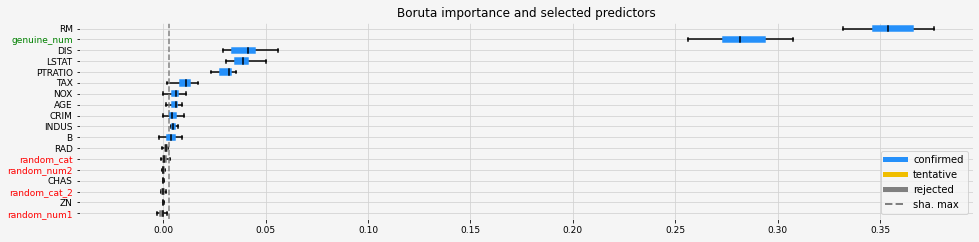

In [10]:
%%time

model = LGBMRegressor(random_state=42, verbose=-1, max_depth=5)

feat_selector = BorutaPy(model, verbose=1, max_iter=20, random_state=42, importance='pimp')#, early_stopping=True, n_iter_no_change=20)
feat_selector.fit(X, y, sample_weight=None)
print(feat_selector.support_names_)
fig = feat_selector.plot_importance(n_feat_per_inch=5)

# highlight synthetic random and genuine variables
fig = highlight_tick(figure=fig, str_match='random')
fig = highlight_tick(figure=fig, str_match='genuine', color='green')

## Boruta with SHAP

Not the original form, same process but using SHAP importance instead of the gini/impurity one.

Boruta iteration:  95%|████████████████████████████████████████████████████████████▊   | 19/20 [00:06<00:00,  2.99it/s]




Boruta finished running using shap var. imp.

Iteration: 	20 / 20
Confirmed: 	10
Tentative: 	0
Rejected: 	8
All relevant predictors selected in 00:00:06.36
['CRIM', 'INDUS', 'NOX', 'RM', 'AGE', 'DIS', 'TAX', 'PTRATIO', 'LSTAT', 'genuine_num']
Wall time: 6.54 s


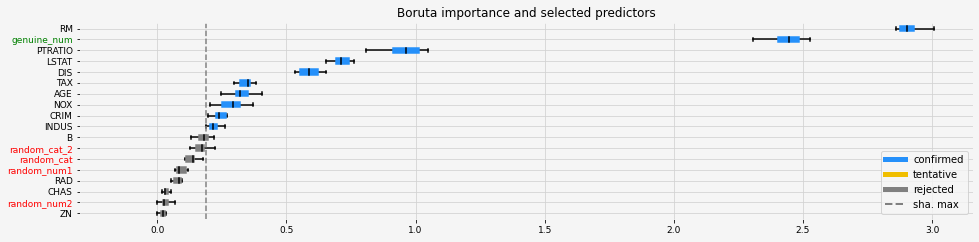

In [11]:
%%time

model = LGBMRegressor(random_state=42, verbose=-1, max_depth=5)

feat_selector = BorutaPy(model, verbose= 1, max_iter= 20, random_state=42, importance='shap')
feat_selector.fit(X, y, sample_weight=None)
print(feat_selector.support_names_)
fig = feat_selector.plot_importance(n_feat_per_inch=5)

# highlight synthetic random and genuine variables
fig = highlight_tick(figure=fig, str_match='random')
fig = highlight_tick(figure=fig, str_match='genuine', color='green')